# Data Preparation

In [ ]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pymysql
import urllib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis, probplot

from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot

from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from arch import arch_model

In [ ]:
# 1) load your creds
load_dotenv()
user     = os.getenv("MYSQL_USER")
raw_pw   = os.getenv("MYSQL_PASSWORD")
password = os.getenv("MYSQL_PASSWORD"),
host     = os.getenv("MYSQL_HOST")
port     = os.getenv("MYSQL_PORT")
db       = os.getenv("MYSQL_DATABASE")

# 2) build the engine
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{db}")

In [34]:
df_tf = pd.read_sql_query(
    "SELECT DISTINCT timeframe FROM ohlcv ORDER BY timeframe;",
    con=engine
)
timeframes = df_tf['timeframe'].tolist()
timeframes

['12h', '15m', '1d', '1h', '1m', '1w', '30m', '3m', '4h', '5m', '6h']

## 1. Description Statistics & Return Distribution

Descriptive Statistics:
   timeframe          mean       std      skew    kurtosis
0        12h  3.446498e-04  0.020863 -0.151711    5.016134
1        15m  7.246309e-06  0.003017 -0.437497   50.471648
2         1d  6.892551e-04  0.029197 -0.179701    3.375157
3         1h  2.894845e-05  0.005919 -0.157904   12.098270
4         1m  4.847337e-07  0.000795 -0.273562  116.350507
5         1w  4.742666e-03  0.073482 -0.216299    1.298690
6        30m  1.450003e-05  0.004238 -0.376501   21.404091
7         3m  9.800510e-07  0.001613 -0.084904   90.280380
8         4h  1.152040e-04  0.011714 -0.105154    7.064387
9         5m  2.518084e-06  0.002139 -0.922980  107.906163
10        6h  1.724454e-04  0.014452 -0.041134    6.531422


/var/folders/3y/9m0_h3_50mbgtyzs2dx_pmc80000gn/T/ipykernel_26027/4023255223.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_ax.boxplot([rets[tf] for tf in timeframes], labels=timeframes)


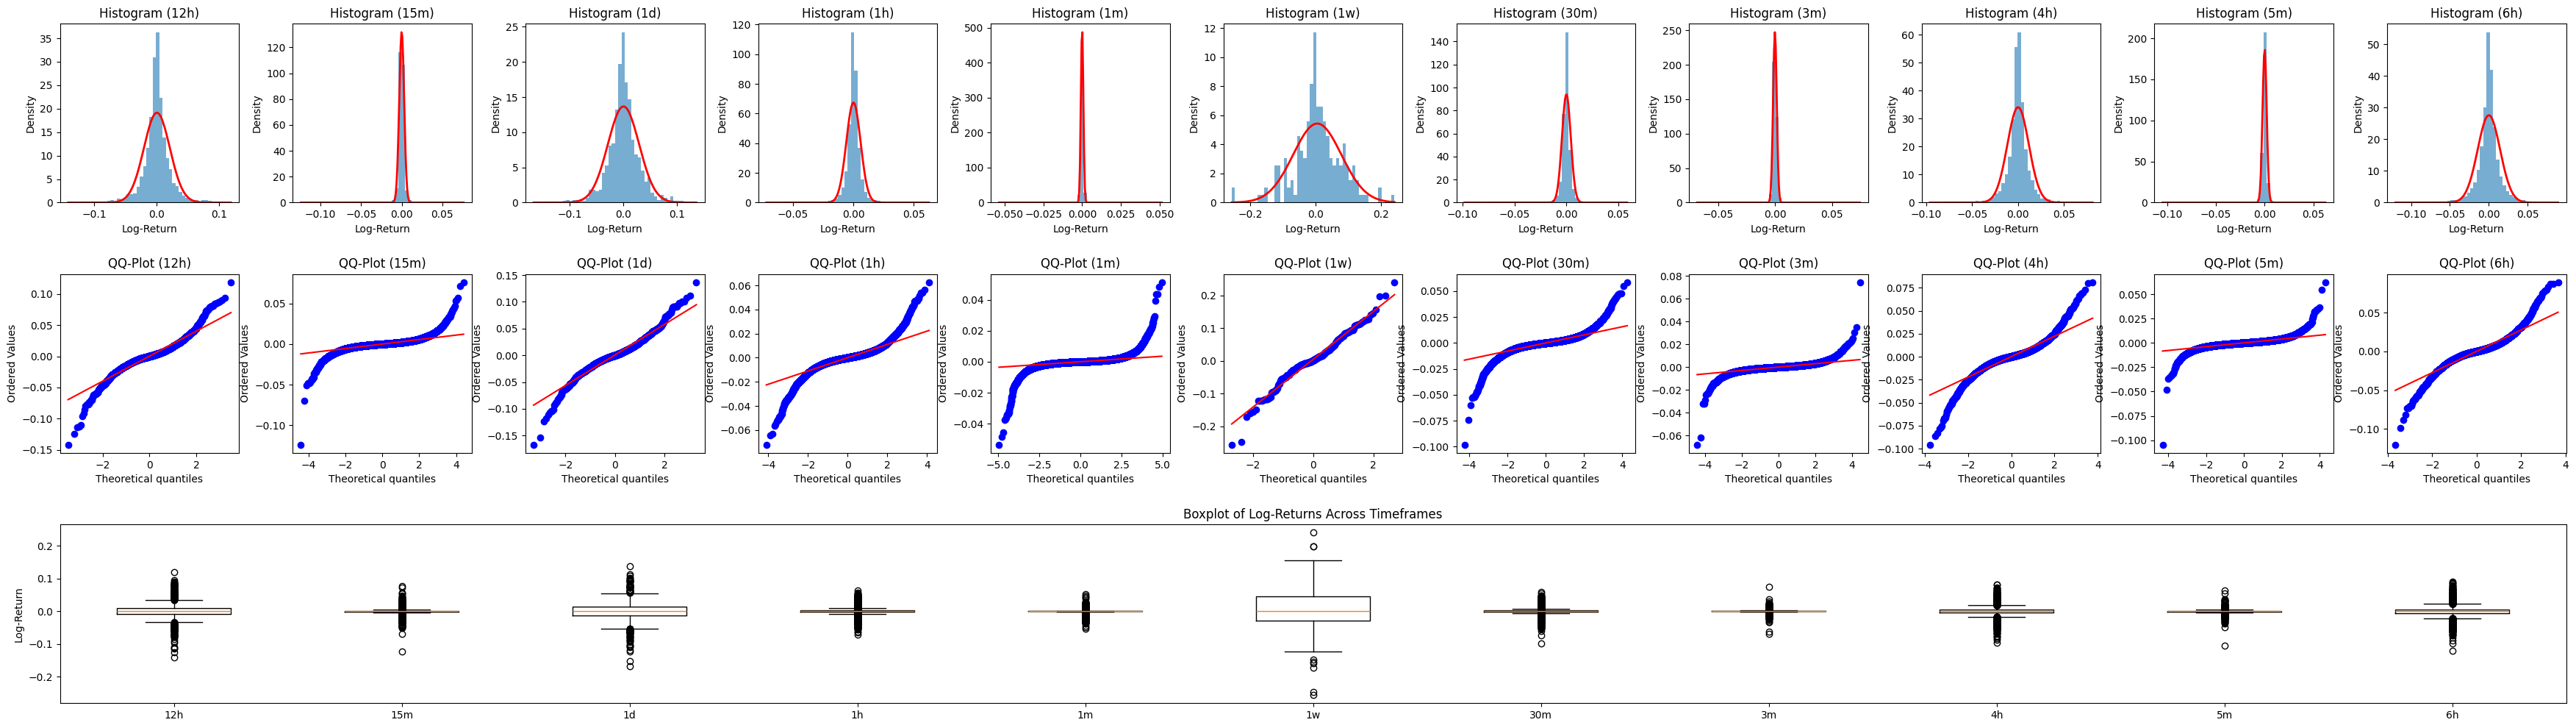

In [ ]:
rets = {}
for tf in timeframes:
    query = f"""
    SELECT timestamp, close
    FROM ohlcv
    WHERE timeframe = '{tf}'
    ORDER BY timestamp
    """
    df = pd.read_sql_query(query, con=engine, parse_dates=['timestamp'])
    df.set_index('timestamp', inplace=True)
    df['ret'] = np.log(df['close'] / df['close'].shift(1))
    rets[tf] = df['ret'].dropna()

stats = []
for tf, series in rets.items():
    stats.append({
        'timeframe': tf,
        'mean': series.mean(),
        'std': series.std(),
        'skew': skew(series),
        'kurtosis': kurtosis(series)
    })
stats_df = pd.DataFrame(stats)
print("Descriptive Statistics:")
print(stats_df)
    
n = len(timeframes)
fig, axes = plt.subplots(3, n, figsize=(4 * n, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Row 1: Histograms with normal overlay
for i, tf in enumerate(timeframes):
    ax = axes[0, i]
    series = rets[tf]
    ax.hist(series, bins=50, density=True, alpha=0.6)
    x = np.linspace(series.min(), series.max(), 200)
    pdf = (1 / (series.std() * np.sqrt(2 * np.pi))) * np.exp(-((x - series.mean())**2) / (2 * series.std()**2))
    ax.plot(x, pdf, 'r', linewidth=2)
    ax.set_title(f"Histogram ({tf})")
    ax.set_xlabel("Log-Return")
    ax.set_ylabel("Density")

# Row 2: QQ‑Plots vs. Gaussian
for i, tf in enumerate(timeframes):
    ax = axes[1, i]
    probplot(rets[tf], dist="norm", plot=ax)
    ax.set_title(f"QQ‑Plot ({tf})")

# Row 3: Boxplot comparison (spanning full width)
# Remove the unused axes in the third row
for j in range(n):
    fig.delaxes(axes[2, j])
box_ax = fig.add_subplot(3, 1, 3)
box_ax.boxplot([rets[tf] for tf in timeframes], labels=timeframes)
box_ax.set_title("Boxplot of Log-Returns Across Timeframes")
box_ax.tick_labels("Log-Return")

plt.show()

In [ ]:
rets = {}
for tf in timeframes:
    query = f"""
    SELECT timestamp, close
    FROM ohlcv
    WHERE timeframe = '{tf}'
    ORDER BY timestamp
    """
    df = pd.read_sql_query(query, con=engine, parse_dates=['timestamp'])
    df.set_index('timestamp', inplace=True)
    df['ret'] = np.log(df['close'] / df['close'].shift(1))
    rets[tf] = df['ret'].dropna()

# 4) Descriptive statistics
stats = []
for tf, series in rets.items():
    stats.append({
        'timeframe': tf,
        'mean': series.mean(),
        'std': series.std(),
        'skew': skew(series),
        'kurtosis': kurtosis(series)
    })
stats_df = pd.DataFrame(stats)
print("Descriptive Statistics:")
print(stats_df)

# 5) Histograms with normal overlay
for tf, series in rets.items():
    plt.figure()
    plt.hist(series, bins=50, density=True)
    x = np.linspace(series.min(), series.max(), 200)
    pdf = (1/(series.std() * np.sqrt(2*np.pi)) *
           np.exp(-((x-series.mean())**2)/(2*series.std()**2)))
    plt.plot(x, pdf)
    plt.title(f"Histogram of Log-Returns ({tf})")
    plt.xlabel("Log-Return")
    plt.ylabel("Density")
    plt.show()

# 6) QQ-Plots vs. Gaussian
for tf, series in rets.items():
    plt.figure()
    probplot(series, dist="norm", plot=plt)
    plt.title(f"QQ-Plot of Log-Returns ({tf})")
    plt.show()

# 7) Boxplot comparison
plt.figure()
plt.boxplot([rets[tf] for tf in timeframes], labels=timeframes)
plt.title("Boxplot of Log-Returns Across Timeframes")
plt.ylabel("Log-Return")
plt.show()

NameError: name 'conn' is not defined